In [1]:
from __future__ import print_function
from tensorflow.keras.layers import Multiply, Add, Concatenate, Dropout, Cropping2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, Conv2DTranspose, UpSampling2D, Reshape
from UpSampling_layer import UpSampling_layer
from feature_scale_fusion_layer_rbm import feature_scale_fusion_layer_rbm
from feature_scale_fusion_layer_learnScaleSel import feature_scale_fusion_layer
from spatial_transformer_v2 import SpatialTransformer_2DTo2D_real as SpatialTransformer
import tensorflow as tf
#import cv2
#from tensorflow.keras.layers import Lambda
import numpy as np
from MyKerasLayers import AcrossChannelLRN
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import cv2
import camera_proj_Zhang as proj

In [3]:
plot_model(a,1)

NameError: name 'a' is not defined

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [ ]:
def unet(base_weight_decay, input_shape):
    
    x = Input(shape=input_shape)
    
    # Conv block 1
    conv1 = Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=64,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_1_1'
    )(x)
    conv1 = Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=64,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_1_2'
    )(conv1)
    pool1 = MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2),
        padding='same',
        #name='pool_1'
    )(conv1)

     # Conv block 2
    conv2 = Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=128,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_2_1'
    )(pool1)
    conv2 = Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=128,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_2_2'
    )(conv2)
    pool2 = MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2),
        padding='same',
        #name='pool_2'
    )(conv2)

     # Conv block 3
    conv3 = Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=256,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_3_1'
    )(pool2)
    conv3 = Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=256,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_3_2'
    )(conv3)
    pool3 = MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2),
        padding='same',
        #name='pool_3'
    )(conv3)

    # Conv block 4
    conv4 = Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=512,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_4_1'
    )(pool3)
    conv4 = Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=512,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_4_2'
    )(conv4)
    pool4 = MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2),
        padding='same',
        #name='pool_4'
    )(conv4)

    # Conv block 5
    conv5 = Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=1024,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_5_1'
    )(pool4)
    conv5 = Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=1024,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_5_2'
    )(conv5)
    

    # conv block 6 with up-sampling
    up6 = Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=512,
        kernel_size=(2, 2),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='up_6'
    )(UpSampling2D(size=(2,2))(conv5))
    up6 = Cropping2D(cropping=((0,0),(0,1)))(up6)
    merge6 = Concatenate(#name='merge_6',
            axis=3)([conv4,up6])

    conv6 =  Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=512,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_6_1'
    )(merge6)
    conv6 =  Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=512,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_6_2'
    )(conv6)

    # conv block 7 with up-sampling
    up7 = Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=256,
        kernel_size=(2, 2),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='up_7'
    )(UpSampling2D(size=(2,2))(conv6))
    up7 = Cropping2D(cropping=((0,1),(0,1)))(up7)
    merge7 = Concatenate(#name='merge_7',
            axis=3)([conv3,up7])

    conv7 =  Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=256,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_7_1'
    )(merge7)
    conv7 =  Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=256,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_7_2'
    )(conv7)

    # conv block 8 with up-sampling
    up8 = Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=128,
        kernel_size=(2, 2),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='up_8'
    )(UpSampling2D(size=(2,2))(conv7))
    #up8 = Cropping2D(cropping=((0,1),(0,1)))(up8)
    merge8 = Concatenate(#name='merge_8',
        axis=3)([conv2,up8])

    conv8 =  Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=128,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_8_1'
    )(merge8)
    conv8 =  Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=128,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_8_2'
    )(conv8)

    # conv block 9 with up-sampling
    up9 = Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=64,
        kernel_size=(2, 2),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='up_9'
    )(UpSampling2D(size=(2,2))(conv8))
    merge9 = Concatenate(#name='merge_9',
        axis=3)([conv1,up9])

    conv9 =  Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=64,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_9_1'
    )(merge9)
    conv9 =  Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=32,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_9_2'
    )(conv9)
    
    '''
    conv9 =  Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=2,
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_9_3'
    )(conv9)

    # conv block 9 with up-sampling
    conv10 = Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=1,
        kernel_size=(1, 1),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_10'
    )(conv9)
    '''
    

    return Model(x,conv9)

In [8]:
input_shape = (380, 676, 3)
unet_test = unet(0.0001,input_shape)

In [9]:
input_1 = Input(batch_shape=(1,380, 676, 3))
input_2 = Input(batch_shape=(1,380, 676, 3))
input_3 = Input(batch_shape=(1,380, 676, 3))

output_1 = unet_test(input_1)
output_2 = unet_test(input_2)
output_3 = unet_test(input_3)

print(output_1.shape)



(1, 380, 676, 32)


In [10]:
output_1 = SpatialTransformer(1, [768, 640])(output_1)
output_2 = SpatialTransformer(2, [768, 640])(output_2)
output_3 = SpatialTransformer(3, [768, 640])(output_3)

output_1 = np.squeeze(output_1,axis=0)
output_2 = np.squeeze(output_2,axis=0)
output_3 = np.squeeze(output_3,axis=0)

In [11]:
print(output_1.shape)

(1, 1, 768, 640, 32)


In [ ]:
output = Concatenate()([output_1,output_2,output_3])

output = Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=64,
        kernel_size=(5, 5),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_9_3'
)(output)
output = Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=32,
        kernel_size=(5, 5),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='relu',
        #name='conv_9_3'
)(output)
output = Conv2D(
        data_format='channels_last',
        trainable=True,
        filters=1,
        kernel_size=(5, 5),
        strides=(1, 1),
        kernel_initializer='he_normal',
        padding='same',
        kernel_regularizer=l2(base_weight_decay),
        use_bias=True,
        activation='sigmoid',
        #name='conv_9_3'
)(output)

In [ ]:
model = Model([input_1,input_2,input_3],output)

In [26]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 380, 676, 3) 0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 380, 676, 3) 0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 380, 676, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 380, 676, 1)  31032837    input_18[0][0]                   
                                                                 input_19[0][0]             

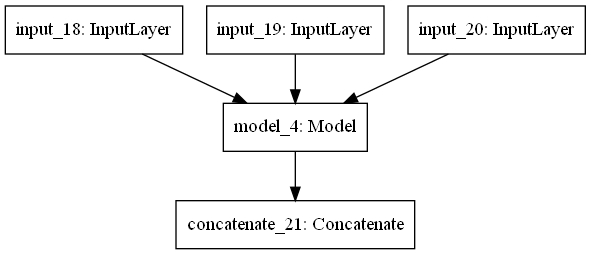

In [27]:
plot_model(model, to_file='model.png')

In [49]:
w = 676
h = 380
W = 640//2
H = 768//2
# D = hi #30/4

bbox = [352 * 0.8, 522 * 0.8]
resolution_scaler = 76.25

image_size = [h, w]
ph = 1.75 * 1000  # average height of a person in millimeters

# nR, fh, fw, fdim = self.tf_static_shape(inputs)

#nR, fh, fw, fdim = inputs.get_shape().as_list()
#self.batch_size, self.gp_x, self.gp_y= nR, W, H


#rsz_h = float(fh) / (h*4)
#rsz_w = float(fw) / (w*4)


grid_rangeX = np.linspace(0, W - 1, W)
grid_rangeY = np.linspace(0, H - 1, H)
# grid_rangeZ = hi # np.linspace(0, D - 1, D)
# grid_rangeX, grid_rangeY, grid_rangeZ = np.meshgrid(grid_rangeX, grid_rangeY, grid_rangeZ)
grid_rangeX, grid_rangeY = np.meshgrid(grid_rangeX, grid_rangeY)

grid_rangeX = np.reshape(grid_rangeX, [-1])
print(grid_rangeX.shape)
print(grid_rangeX[1],' :1')
grid_rangeY = np.reshape(grid_rangeY, [-1])
# grid_rangeZ = np.reshape(grid_rangeZ, [-1])

grid_rangeX = (grid_rangeX*2 - bbox[0])* resolution_scaler
print(grid_rangeX[1],' :2')
grid_rangeX = grid_rangeX + 1
print(grid_rangeX[1],' :3')
grid_rangeX = np.expand_dims(grid_rangeX, 1)

grid_rangeY = (grid_rangeY*2 - bbox[1])* resolution_scaler
grid_rangeY = grid_rangeY + 1
grid_rangeY = np.expand_dims(grid_rangeY, 1)

# grid_rangeZ = grid_rangeZ * 400* np.ones(grid_rangeX.shape)
# grid_rangeZ = np.expand_dims(grid_rangeZ, 1)
grid_rangeZ = ph * np.ones(grid_rangeX.shape)

wldcoords = np.concatenate(([grid_rangeX, grid_rangeY, grid_rangeZ]), axis=1)

(122880,)
1.0  :1
-21319.5  :2
-21318.5  :3


In [50]:
print(wldcoords.shape)

(122880, 3)


In [51]:
 def World2Image(view, wldcoords):
        N = wldcoords.shape[0]
        imgcoords = []
        for i in range(N):
            wldcoords_i = wldcoords[i, :]

            Xw = wldcoords_i[0]
            Yw = wldcoords_i[1]
            Zw = wldcoords_i[2]

            XYi = proj.World2Image(view, Xw, Yw, Zw)
            imgcoords.append(XYi)
        imgcoords = np.asarray(imgcoords)
        return imgcoords

In [52]:
view=1
if view==1:
    view = 'view1'
    view_gp_mask = np.load('coords_correspondence_Street/mask/view1_GP_mask.npz')
if view==2:
    view = 'view2'
    view_gp_mask = np.load('coords_correspondence_Street/mask/view2_GP_mask.npz')
if view==3:
    view = 'view3'
    view_gp_mask = np.load('coords_correspondence_Street/mask/view3_GP_mask.npz')

In [53]:
view_gp_mask = view_gp_mask['arr_0']
view_gp_mask = cv2.resize(view_gp_mask, (W, H))
view_gp_mask = tf.cast(view_gp_mask, 'float32')
view_gp_mask = tf.expand_dims(view_gp_mask, axis=0)
view_gp_mask = tf.expand_dims(view_gp_mask, axis=1)
view_gp_mask = tf.expand_dims(view_gp_mask, axis=-1)

In [54]:
batch_size = 1
num_channels = 3 ###### remember to add the depth dim


view_gp_mask = tf.tile(view_gp_mask, [1,
                                      1, 1, 1, num_channels])
view_gp_mask = tf.cast(view_gp_mask, 'float32')
#view_gp_mask = view_gp_mask
print(wldcoords.shape)
view_ic = World2Image(view,wldcoords)

#view_ic = np.transpose(view_ic)


(122880, 3)


In [55]:
np.savez('./coords_correspondence_Street/projection_forth/view1_new_2.npz',view_ic)

In [56]:
view=2
if view==1:
    view = 'view1'
    view_gp_mask = np.load('coords_correspondence_Street/mask/view1_GP_mask.npz')
if view==2:
    view = 'view2'
    view_gp_mask = np.load('coords_correspondence_Street/mask/view2_GP_mask.npz')
if view==3:
    view = 'view3'
    view_gp_mask = np.load('coords_correspondence_Street/mask/view3_GP_mask.npz')
    
view_gp_mask = view_gp_mask['arr_0']
view_gp_mask = cv2.resize(view_gp_mask, (W, H))
view_gp_mask = tf.cast(view_gp_mask, 'float32')
view_gp_mask = tf.expand_dims(view_gp_mask, axis=0)
view_gp_mask = tf.expand_dims(view_gp_mask, axis=1)
view_gp_mask = tf.expand_dims(view_gp_mask, axis=-1)

batch_size = 1
num_channels = 3 ###### remember to add the depth dim


view_gp_mask = tf.tile(view_gp_mask, [1,
                                      1, 1, 1, num_channels])
view_gp_mask = tf.cast(view_gp_mask, 'float32')
#view_gp_mask = view_gp_mask
print(wldcoords.shape)
view_ic = World2Image(view,wldcoords)

#view_ic = np.transpose(view_ic)
np.savez('./coords_correspondence_Street/projection_forth/view2_new_2.npz',view_ic)

(122880, 3)


In [57]:
view=3
if view==1:
    view = 'view1'
    view_gp_mask = np.load('coords_correspondence_Street/mask/view1_GP_mask.npz')
if view==2:
    view = 'view2'
    view_gp_mask = np.load('coords_correspondence_Street/mask/view2_GP_mask.npz')
if view==3:
    view = 'view3'
    view_gp_mask = np.load('coords_correspondence_Street/mask/view3_GP_mask.npz')
    
view_gp_mask = view_gp_mask['arr_0']
view_gp_mask = cv2.resize(view_gp_mask, (W, H))
view_gp_mask = tf.cast(view_gp_mask, 'float32')
view_gp_mask = tf.expand_dims(view_gp_mask, axis=0)
view_gp_mask = tf.expand_dims(view_gp_mask, axis=1)
view_gp_mask = tf.expand_dims(view_gp_mask, axis=-1)

batch_size = 1
num_channels = 3 ###### remember to add the depth dim


view_gp_mask = tf.tile(view_gp_mask, [1,
                                      1, 1, 1, num_channels])
view_gp_mask = tf.cast(view_gp_mask, 'float32')
#view_gp_mask = view_gp_mask
print(wldcoords.shape)
view_ic = World2Image(view,wldcoords)

#view_ic = np.transpose(view_ic)
np.savez('./coords_correspondence_Street/projection_forth/view3_new_2.npz',view_ic)

(122880, 3)


In [35]:
print(view_ic.shape)

(491520, 3)


In [44]:
rsz_h = float(H) / (h*4)
rsz_w = float(W) / (w*4)

In [45]:
view_ic[0:1, :] = view_ic[0:1, :] * rsz_w
view_ic[1:2, :] = view_ic[1:2, :] * rsz_h
view_ic[2:3, :] = view_ic[2:3, :] # /400

In [46]:
proj_view = np.concatenate(
            [view_ic[0:1, :], view_ic[1:2, :], view_ic[2:3, :]],axis=0)

In [47]:
print(proj_view.shape)

(3, 491520)


In [50]:
proj_view = np.reshape(proj_view,(3,640,768))
proj_view = np.transpose(proj_view,(1,2,0))

In [51]:
print(proj_view.shape)

(640, 768, 3)


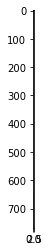

In [53]:
plt.imshow(proj_view[0])

In [36]:
import h5py
view1_h5 = '../../violation_data/train/view3_violation.h5'
view1_data = h5py.File(view1_h5,'r')
print(view1_data.keys())

<KeysViewHDF5 ['color_images', 'density_maps', 'images']>


In [37]:
images = view1_data['color_images']

In [38]:
test_image = images[0]
print(test_image.shape)

(380, 676, 3)


In [39]:
test_image = cv2.resize(test_image,(676,380))

In [40]:
print(test_image.shape)

(380, 676, 3)


In [41]:
from spatial_transformer_v3 import SpatialTransformer_2DTo2D_real as SpatialTransformer

In [42]:
test_image = np.expand_dims(test_image,axis=0)

In [43]:
result = SpatialTransformer(3,[768, 640],scale=1)(test_image)

In [44]:
print(result.shape)

(1, 768, 640, 3)


In [45]:
result = tf.squeeze(result)
print(result)

Tensor("Squeeze_2:0", shape=(768, 640, 3), dtype=float32)


In [46]:
with tf.compat.v1.Session() as sess:
    result = sess.run(result)

In [47]:
print(result.shape)

(768, 640, 3)


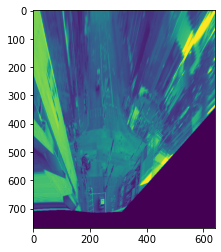

In [48]:
plt.imshow(result[:,:,2])

In [35]:
roi_path = '/public/xiaoxuayu3/CityStreet/ROI_maps/ROIs/camera_view/mask1_ic.npz'
roi = np.load(roi_path)

In [38]:
roi = roi['arr_0']

In [39]:
print(roi.shape)

resize

(1520, 2704)


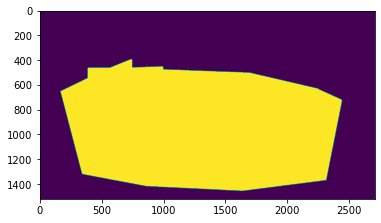

In [40]:
plt.imshow(roi)

In [4]:
from camera_proj_Zhang import Image2World

In [39]:
test_image = cv2.resize(test_image,(2704,1520))
test_image = test_image.astype(np.uint8)

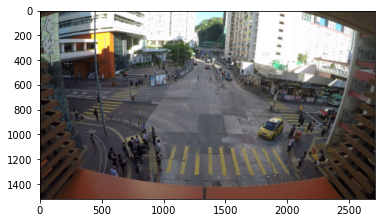

In [48]:
plt.imshow(test_image)
test_image_new = []
test_image_new.append(np.reshape(test_image[:,:,0],[-1]))
test_image_new.append(np.reshape(test_image[:,:,1],[-1]))
test_image_new.append(np.reshape(test_image[:,:,2],[-1]))

In [61]:
test_image_new = np.array(test_image_new)
print(test_image_new[0].shape)

(4110080,)


In [50]:
test_image = Image2World('view1',test_image_new[0],test_image_new[1],test_image_new[2])

In [51]:
test_image = np.array(test_image)

In [52]:
print(test_image.shape)

(3, 4110080)


In [55]:
test_image = np.reshape(test_image,(3,1520,2704))
test_image = np.transpose(test_image,(1,2,0))

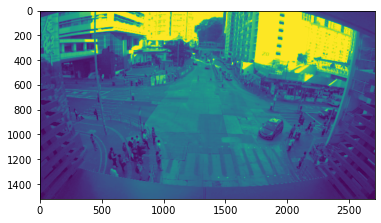

In [60]:
plt.imshow(test_image[:,:,2])